# The relation between criminality and rent prices: a case study of Airbnb in Chicago
<b>Guilherme Araújo & Gabriel Novais</b>:


The goal of this project is to analyze the relationship between the prices of Airbnb listings in Chicago and records of criminal occurences in the city for the period of July 2018 to July 2019.

Why Airbnb? Because price rates are very dynamic, since they operate on a short-term supply-demand equiilibrium, can change daily and can respond almost instanteneously to factors such as criminality, in particular. While some caveats have to be made, since Airbnb listings are likely to be closer to touristic spots and to be less present in poorer neighbourhoods, most listings are made available for most of the year, which suggests host are likely to operate following a short-to-mid term optimization logic. This is not meant as an accurate proxy for long-term (traditional) renting, but as an insight into how the decision-making process (hosts deciding at which prices to list their places for each date, consumers deciding which places to rent given price, location and other factors) can be affected by surrounding criminality. 

How are we doing it? We're going to estimate via linear regression a relationship between 1) prices and nearby criminal occurences, for each day in our sample where we have information on both crimes and Airbnb listings  and 2) variations on listed prices and on nearby criminal occurences, for the listings whose prices were changed by the hosts between the first posting of the listings and the actual renting date.  


<b>Sources and Links</b>:

<b>Airbnb data</b>
<li><a href="http://insideairbnb.com/get-the-data.html">http://insideairbnb.com/get-the-data.html</a></li>

<b>Crimes in Chicago</b>
    <li><a>https://data.cityofchicago.org/Public-Safety/Crimes-One-year-prior-to-present/x2n5-8w5q/data</li></a>

In [0]:
#Setting up Python
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import glob
import re
import io
import requests
import csv

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler
#from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

from math import radians, sin, cos, acos, log, pi, tan, asin,sqrt
from decimal import Decimal
import seaborn as sns
import matplotlib.pyplot as plt
from ast import literal_eval
from scipy import stats
import statsmodels.api as sm

<b> Note: </b> this file was made using Google Colab and expects whoever's running this to be doing so on Colab and to have a Google Drive. If not, file paths may need to be changed when importing the .csv files generated on the 'FDS_part1_data.ipynb' notebook.

In [0]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [0]:
def indices(lst, element):
    result = []
    offset = -1
    while True:
        try:
            offset = lst.index(element, offset+1)
        except ValueError:
            return result
        result.append(offset)

In [0]:
def distance(a,b):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees). Output in KM
    """
    lat1 = a[0]
    lat2 = b[0]
    lon1 = a[1]
    lon2 = b[1]
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    km = 6371 * c
    return km

# PART 2 - STATISTICAL ANALYSIS

First, we'll import the dataframes we created on the 'Part 1 - Data' notebook from Google Drive

In [0]:
airbnb_cr = pd.read_csv("/content/drive/My Drive/airbnb_cr.csv")
cal_change_r = pd.read_csv("/content/drive/My Drive/cal_change_r.csv")

If you didn't save the dataframes as a .csv to your Google Drive, download them from the links below:

airbnb_cr.csv - https://drive.google.com/open?id=1AOv3CrNOysm8FOfgSLL8aWhcWGPRXgPb

cal_change_r.csv - https://drive.google.com/open?id=1-t7ZLlWHe0H_WqgMmYvgCVFLijD5xgNG

# 1 - Airbnb listing prices x nearby crimes on each date 

Our first attempt at understanding how crime and price are related will be through heatmap visualizations. Below, we have heatmaps showing how many nearby crimes occured on average for each month in our sample for all 370 general locations we approximated for our listings. The locations have been sorted by mean price from left to right, such that the left of the map displays criminal occurences near the locations with cheapest mean prices, while the right shows criminality near the most expensive locations.

Below, we have 3 visualizations: all crimes near 1km, all crimes up to 5km* and homicides up to 5km*. 


*Note: on the previous notebook, we calculated crimes on ranges of up to 1km, between 1 and 2km and between 2 and 5km, those 3 sets being disjoint; here, we're adding all counts from those 3 sets)

In [0]:
k=airbnb_cr.groupby(['loc_id']).mean()
k=k.sort_values(by='price')
k=k.reset_index()
k['loc_id2']=k.index
k=k[['loc_id','loc_id2']]

l=airbnb_cr.merge(k)
l.crimes_5km_count=l.crimes_1km_count+l.crimes_2km_count+l.crimes_5km_count
l.homicides_5km_count=l.homicides_1km_count+l.homicides_2km_count+l.homicides_5km_count
airbnb_cr.head()
l=l.groupby(['loc_id2','month','year']).mean()
l=l.reset_index()
l=l.replace({'month': {1: '01', 2: '02', 3: '03', 4: '04', 5: '05', 6: '06', 7: '07', 8: '08', 9: '09'}})
l['year/month']="("+l['year'].map(str)+", "+l['month'].map(str)+")"

([], <a list of 0 Text xticklabel objects>)

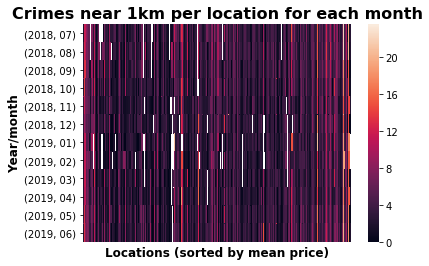

In [0]:
l1=l.pivot('year/month','loc_id2','crimes_1km_count')
g=sns.heatmap(l1)
plt.title('Crimes near 1km per location for each month', fontweight="bold", fontsize=16)
plt.xlabel('Locations (sorted by mean price)', fontweight="demibold", fontsize=12)
plt.ylabel('Year/month', fontweight="demibold", fontsize=12)
plt.xticks([],[])

([], <a list of 0 Text xticklabel objects>)

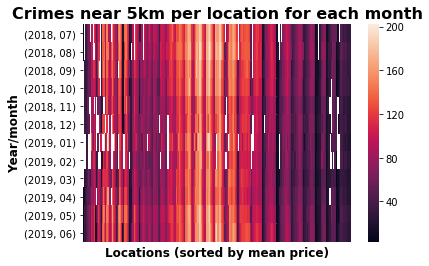

In [0]:
l2=l.pivot('year/month','loc_id','crimes_5km_count')
g=sns.heatmap(l2)
plt.title('Crimes near 5km per location for each month', fontweight="bold", fontsize=16)
plt.xlabel('Locations (sorted by mean price)', fontweight="demibold", fontsize=12)
plt.ylabel('Year/month', fontweight="demibold", fontsize=12)
plt.xticks([],[])

([], <a list of 0 Text xticklabel objects>)

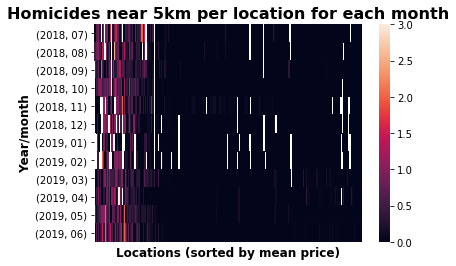

In [0]:
l3=l.pivot('year/month','loc_id','homicides_5km_count')
g=sns.heatmap(l3)
plt.title('Homicides near 5km per location for each month', fontweight="bold", fontsize=16)
plt.xlabel('Locations (sorted by mean price)', fontweight="demibold", fontsize=12)
plt.ylabel('Year/month', fontweight="demibold", fontsize=12)
plt.xticks([],[])

These 3 heatmaps tells us that, in general, criminality is evenly spread across locations, in particular those in the 1km range. However, homicides are almost entirely located near the locations on the bottom third of mean price. From that, we assume that while crimes in general* don't appear to be directly correlated to prices, homicides are much more likely to occur near the places with the cheapest prices, that is, homicides are (strongly) negatively correlated with prices.

*Note: crimes the stealing and violence categories also showcase similar behavior

To test our assumptions that crimes in general are not correlated with prices, but homicides are, we'll perform a linear regression with the datasets we constructed on the previous notebook.

As a preliminary step, we'll check correlations between price and our counts of nearby crimes on the date of the listing.

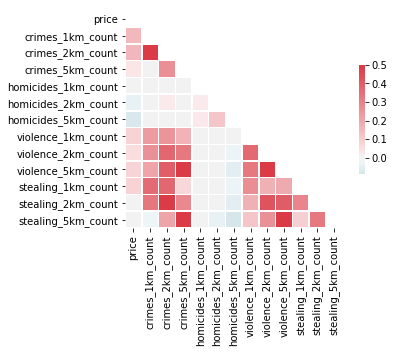

In [0]:
Z=airbnb_cr[['price','crimes_1km_count','crimes_2km_count','crimes_5km_count',
             'homicides_1km_count','homicides_2km_count','homicides_5km_count',
             'violence_1km_count','violence_2km_count','violence_5km_count',
             'stealing_1km_count','stealing_2km_count','stealing_5km_count']]
corr = Z.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.5, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Correlations above are very close to 0, which suggests price and occurences of those types of crimes are not much correlated. With the exception of homicides, crimes still seem to have a very weak but positive correlation with prices. 

Given we have left out so many important variables, we'll have better insight after doing a regression, which will take into account factors such as the type of room (entire home/apt, private room or shared room), neighborhood, listing availability, the listing history (number of reviews, reviews per month), as well as including counts of each of our categories of crime for our 3 radiuses. Note that even when take this into account, we still have a major omitted variable problem, since we don't have any kind of socioeconomical and demographical information other than what's encapsulated by the neighborhood dummy variable, but as said before, this is a rough estimate that's supposed to hint to us whether there's an evidence that nearby criminal occurences influence the supply-demand model for Airbnb listings, particularly on the city of Chicago.

We'll set up our regression by selecting which variables to include, as well as creating dummies for neighbourhoods and room types. Below, we'll check the results of our regression.

In [0]:
X = airbnb_cr[['crimes_1km_count','crimes_2km_count','crimes_5km_count','crimes_count_date',
               'homicides_1km_count','homicides_2km_count','homicides_5km_count','homicides_count_date',
               'violence_1km_count','violence_2km_count','violence_5km_count','violence_count_date',
               'stealing_1km_count','stealing_2km_count','stealing_5km_count','stealing_count_date',
               'room_type','neighbourhood','number_of_reviews','reviews_per_month','availability_365']]
y = airbnb_cr[['price']]

X = pd.concat([X, pd.get_dummies(X.room_type, prefix='room_type', drop_first=True)], axis=1)
X = pd.concat([X, pd.get_dummies(X.neighbourhood, drop_first=True)], axis=1)

X=X.drop(['neighbourhood','room_type'],axis=1)

reg = LinearRegression().fit(X, y)


X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                     448.6
Date:                Mon, 16 Sep 2019   Prob (F-statistic):               0.00
Time:                        02:14:13   Log-Likelihood:            -5.8394e+05
No. Observations:               97060   AIC:                         1.168e+06
Df Residuals:                   96970   BIC:                         1.169e+06
Df Model:                          89                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     30

For further explanation and commentary on the results, check the Report section of our website.

  Above, we have the summary of our first regression. The R squared metric is of 0.292, which is a surprisingly good value given how rough our estimates are (considering we assumed only the data from reviewed dates to be relevant) and how many relevant variables are omitted due to not being available on our datasets (most notably, neighbourhood dummies being our only demographic and socioeconomical variables). 
  To validate our results, we'll do a 5-fold cross_validation:
  

In [0]:
pred_reg = cross_val_predict(reg, X, y, cv=5)
score_reg = cross_val_score(reg, X, y, cv=5)
print('Mean difference between actual price and prediction: ', np.abs(np.mean(np.array(y)-pred_reg))) 
print('Score (for each fold): ',score_reg)
print('Mean score: ', np.mean(score_reg))

Mean difference between actual price and prediction:  0.7652045980765261
Score (for each fold):  [0.23466875 0.25157137 0.31886768 0.27312663 0.28720427]
Mean score:  0.27308774116668433


  The 5-fold cross-validation gave us a mean R squared metric of 0.273 for the 5 folds, which varied between 0.234 and 0.318. This supports our full regression's results as reasonably accurate and consistent.
  The mean difference between the actual price and the predicted price was (in absolute value) 0.765, which suggests a surprisingly accurate prediction, on average.

   Overall, the number of nearby crimes seem to be positively correlated with prices, which we believe to be associated with the higher frequency of reported crimes on richer and more populous areas, while the number of crimes on the date is negatively correlated with prices, although very weakly. Nearby homicides are shown to be strongly negatively correlated with prices, as our exploratory analysis suggested, but the small sample size makes it so the p-value is too small for those results to be considered statistically significant.
  
  Many neighborhood dummies had very high coefficients in absolute value and low p-values, suggesting that there is a strong underlying socioeconomical and demographical factor that can’t be accurately captured by our database (and perhaps, by the distribution of Airbnb listings across the city themselves).


#2 - Airbnb listed price changes x criminal occurences variation

To expand on the results above, we'll perform another linear regression similar to the one before, but this time for our second dataset of listings for which the listing price changed between different dates of the web scraping process that generated our database. The main difference is that we'll predict the difference in prices with the difference in criminal occurences (for each of our categories) between the two scraping dates, as well as the same control variables as before.

As before, first we'll plot the correlations. The results are similar to those from our first dataset.

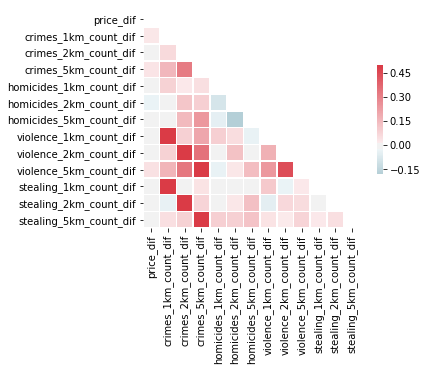

In [0]:
Z=cal_change_r[['price_dif','crimes_1km_count_dif','crimes_2km_count_dif','crimes_5km_count_dif',
             'homicides_1km_count_dif','homicides_2km_count_dif','homicides_5km_count_dif',
             'violence_1km_count_dif','violence_2km_count_dif','violence_5km_count_dif',
             'stealing_1km_count_dif','stealing_2km_count_dif','stealing_5km_count_dif']]

corr = Z.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.5, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Now we'll do a regression considering the difference between scraping dates in regards to price and crime counts. Note that this model implies a very strong (and rough) assumption: that the influence crime had on the price can be measured by the difference in criminal occurences between scraping dates, and nothing more. Again, this is not a very precise estimate but should be able to complement the results from our previous regression.

In [0]:
X = cal_change_r[['crimes_1km_count_dif','crimes_2km_count_dif','crimes_5km_count_dif',
               'homicides_1km_count_dif','homicides_2km_count_dif','homicides_5km_count_dif',
               'violence_1km_count_dif','violence_2km_count_dif','violence_5km_count_dif',
               'stealing_1km_count_dif','stealing_2km_count_dif','stealing_5km_count_dif',
               'room_type','neighbourhood','number_of_reviews','reviews_per_month','availability_365']]
y = cal_change_r[['price_dif']]

X = pd.concat([X, pd.get_dummies(X.room_type, prefix='room_type', drop_first=True)], axis=1)
X = pd.concat([X, pd.get_dummies(X.neighbourhood, drop_first=True)], axis=1)

X=X.drop(['neighbourhood','room_type'],axis=1)

reg = LinearRegression().fit(X, y)

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


                            OLS Regression Results                            
Dep. Variable:              price_dif   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     70.03
Date:                Mon, 16 Sep 2019   Prob (F-statistic):               0.00
Time:                        02:14:19   Log-Likelihood:            -3.6202e+05
No. Observations:               59947   AIC:                         7.242e+05
Df Residuals:                   59862   BIC:                         7.250e+05
Df Model:                          84                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

Most notably, the coefficients associated with the number of nearby homicides are statistically significant while remaining strongly negatively correlated with price. The R squared coefficient is a low 0.089, which is not unexpected even when setting aside the (low) quality of our data for this type of prediction. A 5-fold cross-validation (below) gave us a mean R squared of 0.056 and a mean difference between actual and predicted price of 0.96. The accuracy here is considerably worse than the first regression, but the prediction is on average pretty close to the actual data.

In [0]:
pred_reg = cross_val_predict(reg, X, y, cv=5)
score_reg = cross_val_score(reg, X, y, cv=5)
print('Mean difference between actual price and prediction: ', np.abs(np.mean(np.array(y)-pred_reg))) 
print('Score (for each fold): ',score_reg)
print('Mean score: ', np.mean(score_reg))

Mean difference between actual price and prediction:  0.9672265148857414
Score (for each fold):  [0.00563685 0.07204663 0.08205338 0.040247   0.0800617 ]
Mean score:  0.05600911362788539


#GRAPHS AND VISUALIZATIONS

Check the other notebooks on the GitHub folder for the code for the plots and maps featured on the project website

#PROJECT WEBSITE

For more information on this project, visualizations and the full report, go to www.machinehacks.com